In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import sys
from torch.autograd import Variable


# Данные

In [2]:
df = pd.read_csv('train.csv')
df['hits'].astype('float32')
df.tail()

,date,hits
1091,2018-12-27,241134980
1092,2018-12-28,234865040
1093,2018-12-29,195884690
1094,2018-12-30,125587958
1095,2018-12-31,110355560


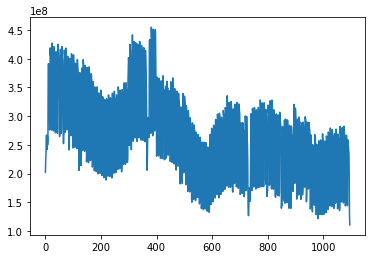

In [3]:
plt.Figure()
plt.plot(df['hits'])

Как выглядит временной ряд в 2018 году

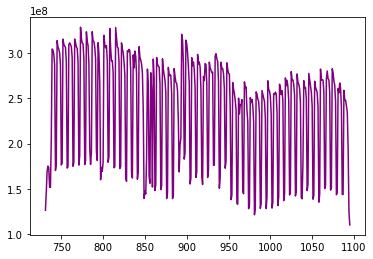

In [4]:
data_2018 = pd.DataFrame(df[df['date'] >= '2018-01-01'])

data_2018

plt.plot(data_2018['hits'], 'purple')

In [5]:
hits = df.hits.values.astype('float32').reshape(-1, 1)
date = df.date.values

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(hits)

In [6]:
train_data.shape

(1096, 1)

In [7]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [8]:
train_size = int(train_data.shape[0] * 0.9)
test_size = train_data.shape[0] - train_size
train, test = train_data[0:train_size,:], train_data[train_size:train_data.shape[0],:]
print(len(train), len(test))

986 110


In [9]:
look_back = 60
look_forward=2
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader =  DataLoader(train_dataset, batch_size=5)
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
test_dataloader =  DataLoader(test_dataset, batch_size=5)

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        if hidden is None:
            h = Variable(torch.zeros(self.hidden_size, inputs.size(0)), requires_grad=False)
            c = Variable(torch.zeros(self.hidden_size, inputs.size(0)), requires_grad=False)
        else:
            h, c = hidden
        bs = h.size(0)
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

In [12]:
class LSTM_network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_network, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, X, hidden):
        output_lstm, _ = self.lstm(X)
        output_lstm = output_lstm.view(X.shape[0], -1)[:,-1].view(-1, 1)
        return output_lstm

In [35]:
class LSTM_cnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_cnn, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear_layer_1 = nn.Linear(hidden_size, 256)
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 32, 4, 2),
                                         nn.ReLU(2), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(32, 64, 2, 2, 1),
                                         nn.ReLU(2)
                                        )
        self.linear_layer_2 = nn.Linear(256, output_size)

    def forward(self, X, hidden):
        output_lstm, _ = self.lstm(X)
        output_lstm = output_lstm.view(X.shape[0], -1)
        output_linear_1 = self.linear_layer_1(output_lstm)
        output_linear_1 = output_linear_1.view(X.shape[0], 1, 16, 16)
        output_conv = self.conv_layers(output_linear_1)
        output_conv = output_conv.view(X.shape[0], -1)
        output = self.linear_layer_2(output_conv)
        return output

# Предсказание

In [260]:
hits = df.hits.values.astype('float32').reshape(-1, 1)
date = df.date.values

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(hits)

In [261]:
train_data.shape

(1096, 1)

In [262]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [269]:
look_back = 90
look_forward = 1
hidden_size = 50
output_size = 1

In [270]:
def train(network, train_loader, epochs, learning_rate, device='cpu'):
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    loss = nn.MSELoss()
    train_loss_epochs = []
    network = network.to(device)
    network = network.train()
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            for X, y in train_loader:
                X = X.type(dtype=torch.FloatTensor)
                X = X.to(device)
                y = y.to(device)
                hidden = (torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device),
                                torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device))
                prediction = network(X, hidden)
                loss_batch = loss(prediction, y)      
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('Epoch {0}... Loss: {1:.5f}'.format(
                        epoch, train_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs)
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs

In [271]:
trainX, trainY = create_dataset(train_data, look_back, look_forward)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader = DataLoader(train_dataset, batch_size=5)

In [310]:
model = LSTM_cnn(look_back, hidden_size, output_size)

Epoch 78... Loss: 0.00324


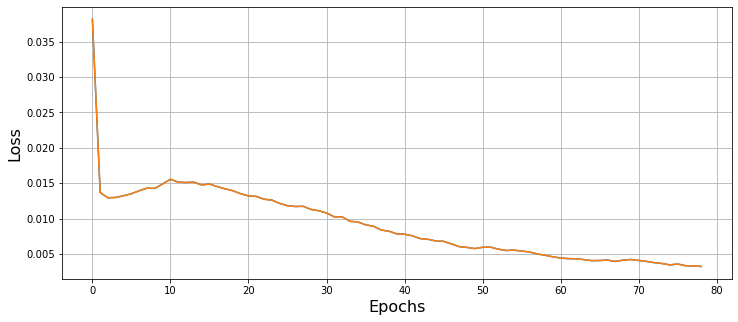

100%|██████████| 79/79 [01:09<00:00,  1.14it/s]


In [311]:
loss = train(model, train_dataloader, 79, 0.001)

In [312]:
test_data = train_data[-look_back:]

In [313]:
def predict(model, hidden_size, test_data, device = 'cpu'):
    predicion = []
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for i in range(365):
            X_test = []
            X_test.append(test_data[i:i+hidden_size, 0])
            X_test = np.array(X_test)
            X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
            X_test = torch.tensor(X_test).type(dtype=torch.FloatTensor).to(device)
            hidden = (torch.zeros(X_test.shape[1], model.hidden_size).type(dtype=torch.FloatTensor).to(device),
                            torch.zeros(X_test.shape[1], model.hidden_size).type(dtype=torch.FloatTensor).to(device))
            y_pred = model(X_test, hidden)
#             print(y_pred)
            predicion.append(y_pred)
            test_data = np.concatenate((test_data, np.array(y_pred).reshape(-1,1)), axis = 0)
    return predicion        

In [314]:
prediction = predict(model, look_back, test_data)
prediction = np.array(prediction).reshape(-1, 1)
prediction = scaler.inverse_transform(prediction)

In [315]:
pred_df = pd.DataFrame()
pred_df['date'] = pd.date_range("2019-01-01", periods=365, freq="D")
pred_df['hits'] = prediction

In [316]:
pred_df

,date,hits
0,2019-01-01,242426960.0
1,2019-01-02,256100512.0
2,2019-01-03,250655040.0
3,2019-01-04,241348816.0
4,2019-01-05,135385104.0
...,...,...
360,2019-12-27,254977744.0
361,2019-12-28,141336656.0
362,2019-12-29,140195408.0
363,2019-12-30,273680672.0


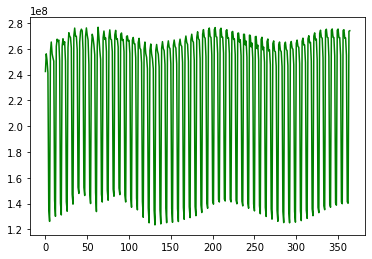

In [317]:
plt.plot(pred_df['hits'], 'g')

In [304]:
pred_df.to_csv('try_lstm_15.csv', index = False)